### Importing Libraries 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('ggplot')

import seaborn as sns

from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,classification_report

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

seed = np.random.seed(21)

###  Loading Train and Test Data

In [2]:
#Loading Train Data 
data_train = pd.read_csv("../input/costa-rican-household-poverty-prediction/train.csv")
display(data_train.shape, data_train.head())

(9557, 143)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [3]:
#Loading Test Data
data_test = pd.read_csv("../input/costa-rican-household-poverty-prediction/test.csv")
display(data_test.shape, data_test.head())

(23856, 142)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


### Inferences from the first view of data -
- There are 142 features and 1 Target field
- **Id** is the unique identifier for each datapoint
- **Target** is an ordinal variable indicating the income levels 
        - 1 : Extreme Poverty
        - 2 : Moderate Poverty
        - 3 : Vulnerable Households
        - 4 : Non-vulnerable Households
            
- **idhogar** is an unique identifier for each houshold. Hence, for household level analysis this feature should be considered.
- **parentesco1** indicates if the person is head of the family
- There are 9556 datapoints in Train Dataset and 23856 datapoints in Test Dataset



## Identify the output variable

The output variable is **Target** column from the dataset.

Test dataset does not have the **Target** column.

It has zero null values.Datatype is int64.

Possible values of **Target** column -
1, 2, 3, 4






## Understand the type of data

In [4]:
data_train_info = pd.DataFrame(columns=['Name of Col', 'Num of Null', 'Dtype', 'N_Unique'])

for i in range(0, len(data_train.columns)):
    data_train_info.loc[i] = [data_train.columns[i],
                        data_train[data_train.columns[i]].isnull().sum(),
                        data_train[data_train.columns[i]].dtypes,
                        data_train[data_train.columns[i]].nunique()] 
data_train_info

#data_train_info.iloc(["Num of Null" != 0])

,Name of Col,Num of Null,Dtype,N_Unique
0,Id,0,object,9557
1,v2a1,6860,float64,157
2,hacdor,0,int64,2
3,rooms,0,int64,11
4,hacapo,0,int64,2
...,...,...,...,...
138,SQBovercrowding,0,float64,38
139,SQBdependency,0,float64,31
140,SQBmeaned,5,float64,155
141,agesq,0,int64,97


## Check if there are any biases in your dataset

In [5]:
#count of unique rows in Target column
data_train["Target"].value_counts()

4    5996
2    1597
3    1209
1     755
Name: Target, dtype: int64

<AxesSubplot:>

Text(0.5, 0, 'Target Values')

Text(0, 0.5, 'Count of Households')

Text(0.5, 1.0, 'Target Column Spread')

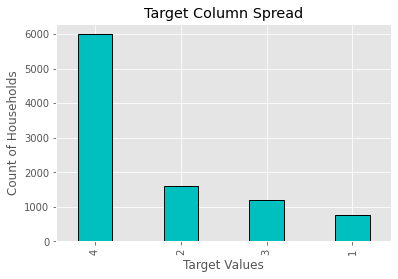

In [6]:
data_train['Target'].value_counts().plot.bar(width = 0.4, color = 'c', edgecolor = 'k', linewidth = 1)
plt.xlabel("Target Values")
plt.ylabel("Count of Households")
plt.title("Target Column Spread")
plt.show()

From the above output, we infer that -

As the extreme poverty is the smallest count, hence the dataset is not biased.

##  Check whether all members of the house have the same poverty level.

In [7]:
#households with same poverty level
poverty_equal = data_train.groupby('idhogar')['Target'].apply(lambda X: X.nunique() == 1) 
#households with un-equal poverty level
poverty_nequal = poverty_equal[poverty_equal != True] 
print("There are {} households where all the family members of the house do not have same poverty level." .format(len(poverty_nequal)))

There are 85 households where all the family members of the house do not have same poverty level.


## Check if there is a house without a family head.

In [8]:
#households with head
household_head = data_train.groupby('idhogar')['parentesco1'].sum()

In [9]:
#households without head
household_without_head = data_train.loc[data_train['idhogar'].isin(household_head[household_head == 0].index), :]
household_without_head["idhogar"].nunique()

15

There are 15 houses without a Family Head

## Set poverty level of the members and the head of the house within a family.

As we found out that there are 15 households without a head. 
First lets check if members of these households have same Target/Povertylevel or different.

In [10]:
#Finding the Households without head and poverty level(Target Value) is different

household_without_head_equal = household_without_head.groupby('idhogar')['Target'].apply(lambda X: X.nunique() == 1) 
print("{} households without head have different PovertyLevel/Target Value." .format(sum(household_without_head_equal == False)))

0 households without head have different PovertyLevel/Target Value.


Hence, we need to focus on only the households with head for setting the poverty levels.

In [11]:
#Now setting poverty level of the members same as the head of the house within a family.
#Iterating through each household

for household in poverty_nequal.index:
    #Finding the correct label(label of house head)
    head_target = int(data_train[(data_train['idhogar'] == household) & (data_train['parentesco1'] == 1.0)] ['Target'])
    #Setting the correct label for family members
    data_train.loc[data_train['idhogar'] == household, 'Target'] = head_target

##  Count how many null values are existing in columns.

In [12]:
data_train_info = pd.DataFrame(columns=['Name of Col', 'Num of Null', 'Dtype', 'N_Unique'])

for i in range(0, len(data_train.columns)):
    data_train_info.loc[i] = [data_train.columns[i],
                        data_train[data_train.columns[i]].isnull().sum(),
                        data_train[data_train.columns[i]].dtypes,
                        data_train[data_train.columns[i]].nunique()] 
data_train_info

,Name of Col,Num of Null,Dtype,N_Unique
0,Id,0,object,9557
1,v2a1,6860,float64,157
2,hacdor,0,int64,2
3,rooms,0,int64,11
4,hacapo,0,int64,2
...,...,...,...,...
138,SQBovercrowding,0,float64,38
139,SQBdependency,0,float64,31
140,SQBmeaned,5,float64,155
141,agesq,0,int64,97


In [13]:
data_train_info[data_train_info["Num of Null"] > 0]

,Name of Col,Num of Null,Dtype,N_Unique
1,v2a1,6860,float64,157
8,v18q1,7342,float64,6
21,rez_esc,7928,float64,6
103,meaneduc,5,float64,155
140,SQBmeaned,5,float64,155


In [14]:
data_train_info["Num of Null"].sum()

22140

Looking at the different datatypes and null values, we infer that -

1. No Null values for integer datatype features.
2. No Null values for object datatype features.
3. For float64 datatype below features has Null values -
   - v2a1 - 6860 values
   - v18q1 - 7342 values
   - rez_esc - 7928 values
   - meaneduc - 5 values
   - SQBmeaned - 5 values 

4. There are total 22140 Null values in the train dataset.


##  Remove null value rows of the target variable.

In [15]:
data_train[data_train["Target"] == 0]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target


Looking at the **Target** column, we observed that there are no null values in Target variable 

## Data Cleaning


### Treating Mixed Values 

In [16]:
# Analysing the top 5 values of dependency, edjefe and dejefa columns 
data_train.loc[:, ["dependency", "edjefe", "edjefa"]].head()

,dependency,edjefe,edjefa
0,no,10,no
1,8,12,no
2,8,no,11
3,yes,11,no
4,yes,11,no


Below listed features have Mixed values-

**dependency**, Dependency rate, calculated = (number of members of the household younger than 19 or older than 64)/(number of member of household between 19 and 64)

**edjefe**, years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0

**edjefa**, years of education of female head of household, based on the interaction ofescolari (years of education), head of household and gender, yes=1 and no=0

For these features, 
"yes" = 1
"no" = 0 

Lets correct these features using a map and coverting these to float

In [17]:
mapping = {'yes' :1, 'no' :0}

for data in [data_train, data_test]:
    data['dependency'] = data['dependency'].replace(mapping).astype(float)
    data['edjefe']=data['edjefe'].replace(mapping).astype(float)
    data['edjefa']=data['edjefa'].replace(mapping).astype(float)
# head output of treated features
data_train.loc[:, ["dependency", "edjefe", "edjefa"]].head()

,dependency,edjefe,edjefa
0,0.0,10.0,0.0
1,8.0,12.0,0.0
2,8.0,0.0,11.0
3,1.0,11.0,0.0
4,1.0,11.0,0.0


As identified in cell 13, below listed features have NaN values- 

 - v2a1 - Monthly rent payment - 6860 values

 - v18q1 - number of tablets household owns - 7342 values

 - rez_esc -Years behind in school - 7928 values

 - meaneduc - average years of education for adults (18+) - 5 values

 - SQBmeaned - square of the mean years of education of adults (>=18) in the household - 5 values

**---------------------------------------------------------------------------------------------------------------------------**

Lets fix v2a1 feature first. Features related to v2a1 (monthly rent payment) -

tipovivi1, =1 own and fully paid house

tipovivi2, =1 own, paying in installments

tipovivi3, =1 rented

tipovivi4, =1 precarious

tipovivi5, =1 other(assigned, borrowed)



In [18]:
data = data_train[data_train['v2a1'].isnull()].head()
data.loc[:, ["v2a1","tipovivi1","tipovivi2","tipovivi3","tipovivi4","tipovivi5"]]

,v2a1,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5
2,NaN,1,0,0,0,0
13,NaN,1,0,0,0,0
14,NaN,1,0,0,0,0
26,NaN,1,0,0,0,0
32,NaN,1,0,0,0,0


<AxesSubplot:>

([<matplotlib.axis.XTick at 0x7f3468552290>,
 [Text(0, 0, 'Owns and Paid Off'),
  Text(1, 0, 'Owns and Paying'),
  Text(2, 0, 'Rented'),
  Text(3, 0, 'Precarious'),
  Text(4, 0, 'Other')])

Text(0.5, 1.0, 'Home-ownership status for Households Missing Rent Payments')

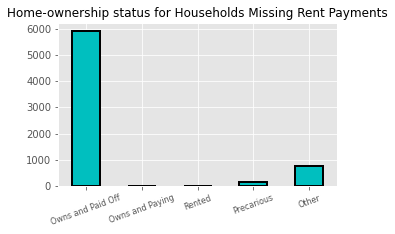

In [19]:
#Features indicating home-ownership

own_feature = [x for x in data_train if x.startswith('tipo')]

#Plotting the home-ownership features for NaN v2a1 rows 

data_train.loc[data_train['v2a1'].isnull(), own_feature].sum().plot.bar(figsize = (5,3), color ='c', edgecolor ='black', linewidth =2)

plt.xticks([0,1,2,3,4],['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],rotation =20, size=8)
plt.title('Home-ownership status for Households Missing Rent Payments', size=12)

From the above counts we infer that, if the house is owned and paid off, then the house rent should be 0. 
Lets add 0 for all the **NaN** values.

In [20]:
for data in [data_train, data_test]:
    data['v2a1'].fillna(value=0, inplace=True)
    
data_train[['v2a1']].isnull().sum()

v2a1    0
dtype: int64

Now, lets fix v18q1 (7342 NaN values) -  number of tablets household owns

Lets analyse few rows with v18q1 feature as NaN, to understand the related features. 
Since this is an household level feature,
therefore we consider the rows for head of the household.


In [21]:
data_train.loc[data_train['parentesco1'] ==1,["v18q","v18q1"]].head()


,v18q,v18q1
0,0,NaN
1,1,1.0
2,0,NaN
5,1,1.0
8,0,NaN


In [22]:
data_train.groupby(by="v18q1")['v18q1'].count()

v18q1
1.0    1586
2.0     444
3.0     129
4.0      37
5.0      13
6.0       6
Name: v18q1, dtype: int64

Looking at above data, we infer that when **owns a tablet** column is 0, then there will be no number of tablets owned by household.

So, lets add 0 for all the NaN values.

In [23]:
for df in [data_train, data_test]:
    df['v18q1'].fillna(value=0, inplace=True)
    
data_train['v18q1'].isnull().sum()

0

Now lets treat rez_esc(Years behind in school) feature - 7928 NaN values

In [24]:
#Checking related features of rez_sec when the value is not Null
data_train[data_train['rez_esc'].notnull()]['age'].describe()

count    1629.000000
mean       12.258441
std         3.218325
min         7.000000
25%         9.000000
50%        12.000000
75%        15.000000
max        17.000000
Name: age, dtype: float64

From the above, we infer that the **Years behind in school** has some value for age value between 7 and 17 Years.
Lets check if there are any NaN values in 7 to 17 Years of age.

In [25]:
data_train[data_train['rez_esc'].isna() & ((data_train['age'] > 7) & (data_train['age'] < 17))]

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
2514,ID_f012e4242,160000.0,0,6,0,1,1,1,1.0,0,...,0,100,9,121,1,2.25,0.25,182.25,100,4


There is only one value as NaN in age group 7 to 17 years.
Hence, now we can fill the NaN values with 0.

In [26]:
for data in [data_train, data_test]:
    data['rez_esc'].fillna(value = 0, inplace = True)

data_train['rez_esc'].isnull().sum()

0

Lets analyze and treat **meaneduc** - average years of education for adults (18+) - 5 values

Few related features -
- edjefe, years of education of male head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- edjefa, years of education of female head of household, based on the interaction of escolari (years of education), head of household and gender, yes=1 and no=0
- instlevel1, =1 no level of education
- instlevel2, =1 incomplete primary


In [27]:
#Lets analyze related features when meaneduc is NaN
data_train[data_train['meaneduc'].isnull()].loc[:,['age','meaneduc','edjefe','edjefa','instlevel1','instlevel2','instlevel3','instlevel4','instlevel5','instlevel6','instlevel7','instlevel8','instlevel9']]

,age,meaneduc,edjefe,edjefa,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
1291,18,NaN,0.0,10.0,0,0,0,1,0,0,0,0,0
1840,18,NaN,4.0,0.0,0,0,1,0,0,0,0,0,0
1841,18,NaN,4.0,0.0,0,1,0,0,0,0,0,0,0
2049,19,NaN,12.0,0.0,0,0,0,0,0,0,1,0,0
2050,19,NaN,12.0,0.0,0,0,0,0,0,0,1,0,0


In [28]:
#Lets analyze related features when meaneduc is not NaN
data_train.loc[:,['Id','meaneduc','edjefe','edjefa','instlevel1','instlevel2','instlevel3','instlevel4','instlevel5','instlevel6','instlevel7','instlevel8','instlevel9']].head()

,Id,meaneduc,edjefe,edjefa,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,ID_279628684,10.0,10.0,0.0,0,0,0,1,0,0,0,0,0
1,ID_f29eb3ddd,12.0,12.0,0.0,0,0,0,0,0,0,0,1,0
2,ID_68de51c94,11.0,0.0,11.0,0,0,0,0,1,0,0,0,0
3,ID_d671db89c,11.0,11.0,0.0,0,0,0,1,0,0,0,0,0
4,ID_d56d6f5f5,11.0,11.0,0.0,0,0,0,0,1,0,0,0,0


From above outputs we infer that -
There are five datapoints with **meaneduc** as NaN. And all have 18+ age.
The value of **meaneduc** feature is same as 'edjefe' if the person is male and 'edjefa' if the person is female for majority of datapoints.

Hence, we treat the 5 NaN values in similar way. 


In [29]:
for data in [data_train,data_test]:
    data['meaneduc'].fillna(value = data['edjefe'], inplace = True)
    
data_train['meaneduc'].isnull().sum()

0

Now, finally lets treat SQBmeaned - square of the mean years of education of adults (>=18) in the household - 5 values

First understand the dependent features to analyze why the 5 values are NaN -

In [30]:
#Related features when SQBmeaned is NaN
data_train[data_train['SQBmeaned'].isnull()].loc[:, ['SQBmeaned','meaneduc','edjefe','edjefa','instlevel1','instlevel2']]

,SQBmeaned,meaneduc,edjefe,edjefa,instlevel1,instlevel2
1291,NaN,0.0,0.0,10.0,0,0
1840,NaN,4.0,4.0,0.0,0,0
1841,NaN,4.0,4.0,0.0,0,1
2049,NaN,12.0,12.0,0.0,0,0
2050,NaN,12.0,12.0,0.0,0,0


In [31]:
#Related features when SQBmeaned is not NaN
data_train.loc[:,['SQBmeaned','meaneduc','edjefe','edjefa','instlevel1','instlevel2']].head()

,SQBmeaned,meaneduc,edjefe,edjefa,instlevel1,instlevel2
0,100.0,10.0,10.0,0.0,0,0
1,144.0,12.0,12.0,0.0,0,0
2,121.0,11.0,0.0,11.0,0,0
3,121.0,11.0,11.0,0.0,0,0
4,121.0,11.0,11.0,0.0,0,0


As per **SQBmeaned** description and above outputs, it appears that SQBmeaned is square of the **meaneduc**. 
Hence, treating the NaN accordingly -

In [32]:
for data in [data_train,data_test]:
    data['SQBmeaned'].fillna(value = data['meaneduc']**2, inplace = True)
    
data_train['SQBmeaned'].isnull().sum()

0

There are some Squared Variables and we understand that these would not add any value to the classification model.
Hence dropping these features -
SQBescolari, SQBage, SQBhogar_total, SQBedjefe, SQBhogar_nin, SQBovercrowding, SQBdependency, SQBmeaned, agesq

In [33]:
#Dropping squared features
cols = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

for df in [data_train, data_test]:
    df.drop(columns=cols, inplace=True)

print(data_train.shape, data_test.shape)

(9557, 134) (23856, 133)


In [34]:
#Checking for the household redundant variables 

heads = data_train.loc[data_train['parentesco1'] == 1, :]
heads.shape

(2973, 134)

In [35]:
corr_matrix = heads.corr()
corr_matrix

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,Target
v2a1,1.000000,-0.022945,0.096752,-0.021961,0.024083,0.045291,0.179476,0.202622,0.025942,-0.029886,...,0.168408,-0.039600,-0.023930,-0.077042,-0.090304,-0.067789,0.141330,-0.141330,-0.205431,0.166112
hacdor,-0.022945,1.000000,-0.181283,0.624324,-0.143713,-0.055073,-0.061309,-0.056616,0.186709,0.057368,...,-0.029605,0.010581,0.026791,-0.010283,0.025574,0.001103,0.025404,-0.025404,-0.090660,-0.136275
rooms,0.096752,-0.181283,1.000000,-0.172382,0.136410,0.158394,0.263738,0.271945,-0.039824,0.232702,...,0.210526,-0.069091,-0.132380,-0.028103,-0.097762,-0.055276,0.126715,-0.126715,0.189562,0.201019
hacapo,-0.021961,0.624324,-0.172382,1.000000,-0.154749,-0.062110,-0.051432,-0.045953,0.174432,0.088729,...,-0.032999,0.018682,0.007766,0.000237,0.007112,0.025496,0.015219,-0.015219,-0.053421,-0.096313
v14a,0.024083,-0.143713,0.136410,-0.154749,1.000000,0.192954,0.029549,0.027883,-0.036434,0.019440,...,0.018571,-0.007181,-0.015806,0.006585,-0.021979,0.005262,-0.018117,0.018117,0.031887,0.068230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lugar6,-0.067789,0.001103,-0.055276,0.025496,0.005262,-0.053853,-0.081023,-0.080580,0.037855,0.030872,...,-0.348073,-0.091332,-0.076929,-0.086971,-0.092448,1.000000,-0.247387,0.247387,-0.036605,-0.047958
area1,0.141330,0.025404,0.126715,0.015219,-0.018117,0.066396,0.167636,0.157366,-0.034287,-0.043043,...,0.375230,-0.102796,-0.009893,-0.184287,-0.123131,-0.247387,1.000000,-1.000000,0.046851,0.089509
area2,-0.141330,-0.025404,-0.126715,-0.015219,0.018117,-0.066396,-0.167636,-0.157366,0.034287,0.043043,...,-0.375230,0.102796,0.009893,0.184287,0.123131,0.247387,-1.000000,1.000000,-0.046851,-0.089509
age,-0.205431,-0.090660,0.189562,-0.053421,0.031887,0.038315,-0.082681,-0.076773,-0.292030,0.048152,...,0.088904,0.004921,-0.046924,-0.025493,-0.057551,-0.036605,0.046851,-0.046851,1.000000,0.026581


In [36]:
#Selecting the upper traingle of corr_matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))

In [37]:
#Finding the index of feature columns with correlation greater than 0.95
cols_to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

cols_to_drop

['tamhog', 'hhsize', 'coopele', 'female', 'hogar_total', 'area2']

In [38]:
#Dropping the cols_to_drop features
for df in [data_train, data_test]:
    df.drop(columns=cols_to_drop, inplace=True)

#Removing the male as well, as this would not be needed in model creation
for df in [data_train, data_test]:
    df.drop(columns = 'male',inplace=True)


#dropping 'Id' and 'idhogar' columns 
cols = ['Id','idhogar']
for df in [data_train,data_test]:
    df.drop(columns= cols, inplace=True)

print(data_train.shape, data_test.shape)

(9557, 125) (23856, 124)


##  Predict the accuracy using random forest classifier.

In [39]:
#Defining features and target variable
X = data_train.drop('Target', axis=1)
y = data_train['Target']

In [40]:
#Checking shape of X and y
print("Shape of X is {}, and shape of y is {}".format(X.shape, y.shape))

Shape of X is (9557, 124), and shape of y is (9557,)


In [41]:
#Splitting train and test data
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.1)

In [42]:
#instantiating the Random Forest Classifier with n_estimator as 150
rfc_model = RandomForestClassifier(n_estimators=150)

In [43]:
#Fitting the model
rfc_model.fit(X_train,y_train)

RandomForestClassifier(n_estimators=150)

In [44]:
#Predicting the y_pred_test
y_pred_test = rfc_model.predict(X_test)

In [45]:
#Checking accuracy score, confusion matrix and classification report on test data
print("Accuracy score of RFC model on test dataset is : ")
print(accuracy_score(y_test, y_pred_test))
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

Accuracy score of RFC model on test dataset is : 
0.9612970711297071
[[ 60   2   0   7]
 [  2 142   0   8]
 [  0   0 109  16]
 [  0   0   2 608]]
              precision    recall  f1-score   support

           1       0.97      0.87      0.92        69
           2       0.99      0.93      0.96       152
           3       0.98      0.87      0.92       125
           4       0.95      1.00      0.97       610

    accuracy                           0.96       956
   macro avg       0.97      0.92      0.94       956
weighted avg       0.96      0.96      0.96       956



 ##  Check the accuracy using random forest with cross validation.

In [46]:
#Defining cross validation generator and calculating cross_val_score
kfold = KFold(n_splits=4,random_state=seed,shuffle=True)
print(cross_val_score(rfc_model, X, y, cv=kfold, scoring='accuracy'))

[0.93849372 0.94390959 0.9464211  0.94181666]


In [47]:
#Mean of cross_val_score
print(cross_val_score(rfc_model, X, y, cv=kfold, scoring='accuracy').mean())

0.9392059316497685


## Checking for the important and impactful features

In [48]:
feature_labels = list(X)
feature_importance = pd.DataFrame({'Feature' : feature_labels, 'Importance' : rfc_model.feature_importances_})

In [49]:
feature_importance[feature_importance['Importance']>0.025]

,Feature,Importance
2,rooms,0.026007
89,hogar_nin,0.032077
92,dependency,0.044786
93,edjefe,0.031589
95,meaneduc,0.071796
106,overcrowding,0.036035
115,qmobilephone,0.029486


Note - From the above we infer that features **room, hogar_nin, dependency, edjefe, meaneduc, overcrowding and qmobilephone** 
play an important role deciding the Income Qualification Level.

## End of the Notebook